# Twitter US Airline Sentiment

## Objective

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Import Libraries

In [34]:

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup                           # Import BeautifulSoup.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##Load Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/Tweets.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

df.head()  

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Data Exploration

In [9]:
df['tweet_id'].groupby(df["airline_sentiment"]).count()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: tweet_id, dtype: int64

In [10]:
df['tweet_id'].groupby(df["negativereason"]).count()

negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
Name: tweet_id, dtype: int64

In [11]:
df['tweet_id'].groupby(df["airline"]).count()

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: tweet_id, dtype: int64

In [12]:
df['tweet_id'].groupby(df["airline_sentiment_gold"]).count()

airline_sentiment_gold
negative    32
neutral      3
positive     5
Name: tweet_id, dtype: int64

In [13]:
df['tweet_id'].groupby(df["negativereason_gold"]).count()

negativereason_gold
Bad Flight                                   1
Can't Tell                                   3
Cancelled Flight                             3
Cancelled Flight\nCustomer Service Issue     2
Customer Service Issue                      12
Customer Service Issue\nCan't Tell           1
Customer Service Issue\nLost Luggage         1
Flight Attendant Complaints                  1
Late Flight                                  4
Late Flight\nCancelled Flight                1
Late Flight\nFlight Attendant Complaints     1
Late Flight\nLost Luggage                    1
Lost Luggage\nDamaged Luggage                1
Name: tweet_id, dtype: int64

In [14]:
df_t = df[['airline_sentiment','text']]

In [15]:
df_t.shape

(14640, 2)

In [16]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

df_t.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [17]:
df_t.isnull().sum(axis=0)   

airline_sentiment    0
text                 0
dtype: int64

# Data Preprocessing

##Remove html tags



In [18]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df_t['text'] = df_t.loc[:,'text'].apply(lambda x: strip_html(x))
df_t.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


## Replace Contractions

In [19]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df_t['text'] = df_t['text'].apply(lambda x: replace_contractions(x))
df_t.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


## Remove Numbers

In [20]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

df_t['text'] = df_t['text'].apply(lambda x: remove_numbers(x))
df_t.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


## Tokenization

In [21]:
df_t['text'] = df_t.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
df_t.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


## Remove Stopwords, Punctuation, & Lemmatize

In [23]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))    

In [24]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df_t['text'] = df_t.apply(lambda row: normalize(row['text']), axis=1)
df_t.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


#Vectorization

###Count Vectorizer


In [25]:
# Vectorization (Convert text data to numbers).

vectorizer = CountVectorizer(max_features=10000)                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(df_t['text'])

data_features_CV = data_features.toarray()                        # Convert the data features to array.

data_features_CV.shape

(14640, 10000)

## TfidVectorizer

In [26]:
# Using TfidfVectorizer to convert text data to numbers.

vectorizer = TfidfVectorizer (max_features=10000,  ngram_range=(1, 2))
data_features = vectorizer.fit_transform(df_t['text'])

data_features_TF = data_features.toarray()

data_features_TF.shape

(14640, 10000)

#Model Creation

##Create the Model 

In [27]:
labels = df_t['airline_sentiment']


In [28]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(data_features_CV, labels, test_size=0.3, random_state=42)

In [29]:
# Split data into training and testing set.

X_traintf, X_testtf, y_traintf, y_testtf = train_test_split(data_features_TF, labels, test_size=0.3, random_state=42)

### Random Forest Classifier - Count Vectorizer

In [30]:
# Using Random Forest to build model for the classification of reviews.

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_train, y_train)
y_prediction = forest.predict(X_test)
accuracyRF = accuracy_score(y_test, y_prediction)
print('RandomForestTestAccuracy:',"{:.2f}".format(accuracyRF*100))
print('RandomForestCVAccuracy:',np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestTestAccuracy: 75.61
RandomForestCVAccuracy: 0.7126366120218579


### Linear SVC - Count Vectorizer

In [31]:
 #  Using SVC to build model for the classification of reviews.

SVC = LinearSVC()
SVC.fit(X_train, y_train)
y_prediction = SVC.predict(X_test)
accuracySVC = accuracy_score(y_test, y_prediction)
print('SVCTestAccuracy:',"{:.2f}".format(accuracySVC*100))
print('SVC-CVAccuracy:',np.mean(cross_val_score(SVC, data_features, labels, cv=10)))


SVCTestAccuracy: 77.64
SVC-CVAccuracy: 0.7584016393442623


### Random Forest Claissfier - TFID

In [32]:
# Using Random Forest to build model for the classification of reviews.

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_traintf, y_traintf)
y_predictiontf = forest.predict(X_testtf)
accuracyRFTF = accuracy_score(y_testtf, y_predictiontf)
print('RandomForest-TFID-TestAccuracy:',"{:.2f}".format(accuracyRFTF*100))
print('RandomForest-TFId-CVAccuracy:',np.mean(cross_val_score(forest, data_features_TF, labels, cv=10)))

RandomForest-TFID-TestAccuracy: 76.28
RandomForest-TFId-CVAccuracy: 0.7177595628415301


### SVC TFidVectorizer

In [33]:
 #  Using SVC to build model for the classification of reviews.

SVC = LinearSVC()
SVC.fit(X_traintf, y_traintf)
y_predictiontf = SVC.predict(X_testtf)
accuracySVC = accuracy_score(y_testtf, y_predictiontf)
print('SVCTest-TFID-Accuracy:',"{:.2f}".format(accuracySVC*100))
print('SVC-CV-TFID-Accuracy:',np.mean(cross_val_score(SVC, data_features_TF, labels, cv=10)))


SVCTest-TFID-Accuracy: 79.19
SVC-CV-TFID-Accuracy: 0.7584016393442623


## Conclusion 
SVC has the highest accuracy of 79% and cross validation of 75% so we would go with SVC and TfidVectorizer.

#### Print Confusion Matrix -Random Forest

[[2541  221   52]
 [ 343  467   74]
 [ 140   84  470]]


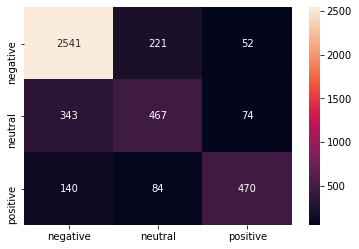

In [35]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

conf_mat = confusion_matrix(y_testtf, y_predictiontf)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, index = [i for i in ("negative","neutral","positive")],
                  columns = [i for i in ("negative","neutral","positive")])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, fmt='g')

#Summary and Conclusion

In this project the objective was to analyze Twitter Tweets for Airlines and classify them as positive, negative or neutral. Before creating a model we applied several techniques to cleanse and process the data in order to make it usable for machine learning. We took the following steps:

*   Removal of html tags, special charachters such as @ signs and accented charachters 
*   Lowercasing
*   Removed Numbers 
*   Replaced contractions
*   Stop-word removal
*   Lematize - to get the root word for a verb

After preprocessing the data we used and compared two vetrorization techniques :
*   Count Vectorizer 
*   TfidVectorizer  

We also used two different models 
*   Random Forest 
*   SVC 

In conclusion Tfid Vectorizer and SVC model worked best with our data and gave us an accuracy of 79%